## Interactive Weak Supervision for NLP

### Lesson 1:

**What is weak Supervision**

Noisy Sources are used  to provide supervisions  for labeling large amount of training data 

**Why Not Hand Labeling?**

Expensive ,time consuming and can sometimes be cost prohibitive if SME(Subject Matter Expert) are ncesessary in the labeling process (i.e : doctors in medical contexts)

**Why not active leanring?Why not synthetic data?**

Active learning and synthetic data generation are both useful techniques. There is no one-size-fits-all ML techniques to solve all labeling problems 
Weak Supervision is useful when domain experties can be discretely encoded and used to bosstrap the labeling process

3 key figures that a data scientist or subject matter experts(SME) can leverage in order to gauge the performance of probabilistic models and use the performance as encoded by the figures to iterate on the model


**Base rate distribution** 
<br>
**Probabilistic confusion index**
<br>
**Label prediction Index**

The first step is to hand label a small sample of data. The data we'll be working with here is the medical transcription dataset from kaggel and the task is to predict whether any transciption involved surgery, as given by "medical speciality" column.We will use this column to hand label sveral rows, for pedagogical purpose,but this will usually be an SME looking through the transcription to label the rows. Let's Jump in and have a look at our data 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
sns.set()
df = pd.read_csv(r"C:\Users\soumy\ML_Projects\CSV_FILES\mtsamples.csv\mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Base rate distribution -> How often  the class A is  appear from the whole data 

Probabilistic confusion index -> This is an confustion matrix used when target label is multiclass rather than just binary

Label prediction Index -> The distribution of labels througout the dataset

In [32]:
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [33]:
#hand label some rows
N= 250
df = df.sample(frac=1,random_state=42).reset_index()
df_labeled = df.iloc[:N]
df_unlabeled = df.iloc[N:]
df_labeled['label'] = (df_labeled["medical_specialty"].str.contains('Surgery') == 1).astype(int)
df_unlabeled['label'] = None
df_labeled.head()

,index,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,label
0,84,84,An example/template for meatotomy.,Urology,Meatotomy Template,"OPERATIVE NOTE: ,The patient was taken to the...","urology, urethral meatus, mosquito hemostat, m...",0
1,2470,2470,Normal physical exam template. Normal appear...,Office Notes,Normal Physical Exam Template - 6,"VITAL SIGNS:, Reveal a blood pressure of *, t...","office notes, jugular venous distention, flank...",0
2,2804,2804,Neurologic consultation was requested to asse...,Neurology,Neurologic Consultation - 3,"HISTORY: , Neurologic consultation was request...","neurology, eye blinking, status epilepticus, s...",0
3,4987,4987,"Multiple sharp force injuries, involving ches...",Autopsy,Autopsy - 6,"ANATOMICAL SUMMARY,1. Sharp force wound of nec...",NaN,0
4,4924,4924,The patient with atypical type right arm disc...,Cardiovascular / Pulmonary,Cardiac Catheterization - 2,"INDICATIONS FOR PROCEDURE:, The patient has pr...","cardiovascular / pulmonary, discomfort, subcla...",0


In [34]:
#Base Rate Calulation
base_rate = sum(df_labeled['label'])/len(df_labeled['label'])
f"Base Rate = {base_rate}"

'Base Rate = 0.24'

## LESSON 2 : Probalistic Weak Level Evaluation

### The Base Rate distribution

Base Rate Distribution : What do you mean by "distribution" here, given that we have an actual base rate?
Well,one way to think about it is that we have calculated the base rate from a sample of data.This means that we don't know the
exact base rate and our uncertainly around it can be chracterized by a distribution.One way to formulate this uncertainly is using Bayesian Technique and,essentially,our knowledge about the base rate is encoded by the posterior distribution.You don't need to know  too much about the  Baysian methiods to get the gist of it but if you would like to know more, then we you can check out some introductry material here. 

In [5]:
# Plot for Base Rate Distribution and the distinrution of labed data above
def plot_posterior(df,xlabel,ylabel):
    N= len(df)
    #Flip coins
    n_successess = df.label.sum()
    
    #X-axis for PDF
    x= np.linspace(0,1,100)
    
    #Write one equation for uniform prior
    prior = np.ones(len(x))
    
    #write one euqation for posterior, whihc is likelyhood* prior
    posterior =  (x**n_successess) * ((1-x)**(N-n_successess)) * prior
    
    
    #pseudo-normalize the posterior so that we can compaire them in the same scale
    posterior /= np.max(posterior)
    
    
    #plor posterier
    plt.plot(x,posterior)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    
    
    

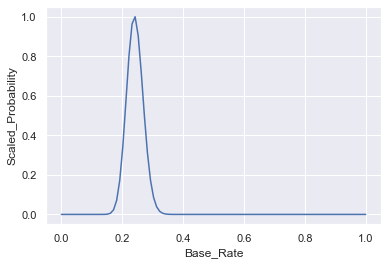

In [6]:
#plot the base label distribution
plot_posterior(df_labeled, "Base_Rate","Scaled_Probability")

In [7]:
def plot_posterior_flip(p=0.6,N=0):
    np.random.seed(42)
    n_successess = np.random.binomial(N,p)
    x = np.linspace(0,1,100)
    prior =1
    posterior = x**n_successess *(1-x) ** (N-n_successess) * prior
    posterior /= np.max(posterior)
    plt.plot(x,posterior)
    plt.xlabel('p')
    plt.ylabel('N')

In [8]:
from ipywidgets import widgets
widgets.interact(plot_posterior_flip, p =(0, 1, 0.01), N =(0, 1500));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

## Programmatic Labeling with Domain Hinter

In [9]:
# Search for  word "ANESTHESIA"
df1 = pd.concat([df_labeled,df_unlabeled])


In [10]:
df1.shape

(4999, 8)

In [11]:
df1['transcription'].str.contains('ANESTHESIA').sum()

1319

In [12]:
#creat columns to encode hinter result
df1['h1'] = df1['transcription'].str.contains('ANESTHESIA')


W = 0.95
L= []
for index,row in df1.iterrows():
    if df1.iloc[index]['h1']:
        P1 = (base_rate + W)/2
        L.append(P1)
    else:
        P1 = base_rate
        L.append(P1)
df1['P1'] = L

df1.P1.value_counts()

0.240    3647
0.595    1352
Name: P1, dtype: int64

In [13]:
df1.P1. 

SyntaxError: invalid syntax (Temp/ipykernel_19652/2619761596.py, line 1)

### The Probalistic Confusion Index

(0.0, 1.0)

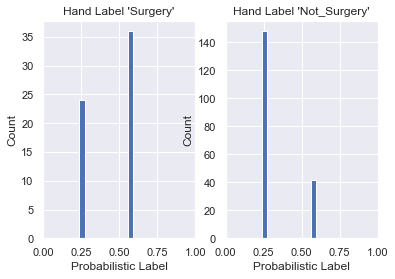

In [63]:
plt.subplot(1,2,1)
df1[df1.label == 1].P1.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
plt.xlim([0,1])
plt.subplot(1,2,2)
df1[df1.label == 0].P1.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
plt.xlim([0,1])



We here see that 
<br>
* The majority of data labeled 'Surgery' has P(S) around 0.60 (through not much) and the rest around 0.24
* The rows hand labeled 'Not Surgery' Have P(S) around 0.24 and the rest around 0.60

This is a good start,in that P(S) is skewed to the left for those label "Not Surgery" and to the right for those labeled "Surgery".However,we would want it skewed far closer to P(S)=1 for those label Surgeryso there's still work to do. 

## Label Distribution Plot

The next key plot is the label prediction distribution plot across the dataset: we want to see how our label predictions are distributed and whether this matches up to what we know of our base rate. For example, in our case, we know that our base rate is likely somewhere around 25%. So what we would expect to see in the label distribution is -25% of our dataset with a near 100% chance of being surgery and -75% of it with a low chance of being surgery.

<AxesSubplot:ylabel='Density'>

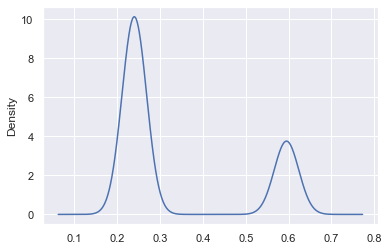

In [64]:
df1.P1.plot.kde()

We see peaks at -25% and -60%, which means that our model really doesn't yet have a strong sense of the label and so we want to add more hinters. Essentially, we'd really like to see our probabilistic predictions closer to ) and 1, in a proportion that respects the base rate.

### Building more Hinters


To build better labels, we can inject more domain expertise by adding more hinters. We do this below by adding two more positive hinters (ones that are correlated with 'Surgery'), which alter our predicted probability in a manner analogous to the hinter above.

In [14]:
#Create columns to encode Hinters
df1['h2'] = df1['transcription'].str.contains('blade')
#Hinter will alter P(S): 1st approx. if row is +ve wrt to hinter,take average, if row is -ve do nothing
# Update P(S) as follows
# if h1 is false, do nothing
#if h1 is true then, then take average P(S)  and  Weight(0.95),unless labeled

W =0.95
L= []
for index,row in df1.iterrows():
    if df1.iloc[index]['h2']:
        P2 = (df1.iloc[index]['P1'] +W)/2
        L.append(P2)
    else:
        P2 = df1.iloc[index]['P1']
        L.append(P2)
        
df1['P2'] = L



(0.0, 1.0)

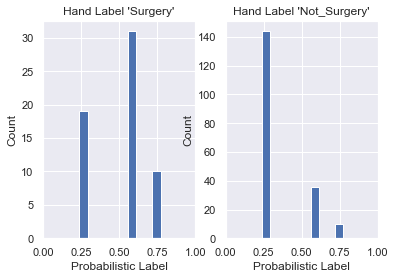

In [15]:
plt.subplot(1,2,1)
df1[df1.label == 1].P2.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
plt.xlim([0,1])
plt.subplot(1,2,2)
df1[df1.label == 0].P2.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
plt.xlim([0,1])

In [16]:
df1.head()

,index,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,label,h1,P1,h2,P2
0,84,84,An example/template for meatotomy.,Urology,Meatotomy Template,"OPERATIVE NOTE: ,The patient was taken to the...","urology, urethral meatus, mosquito hemostat, m...",0,False,0.240,False,0.240
1,2470,2470,Normal physical exam template. Normal appear...,Office Notes,Normal Physical Exam Template - 6,"VITAL SIGNS:, Reveal a blood pressure of *, t...","office notes, jugular venous distention, flank...",0,False,0.240,False,0.240
2,2804,2804,Neurologic consultation was requested to asse...,Neurology,Neurologic Consultation - 3,"HISTORY: , Neurologic consultation was request...","neurology, eye blinking, status epilepticus, s...",0,False,0.240,False,0.240
3,4987,4987,"Multiple sharp force injuries, involving ches...",Autopsy,Autopsy - 6,"ANATOMICAL SUMMARY,1. Sharp force wound of nec...",NaN,0,False,0.240,False,0.240
4,4924,4924,The patient with atypical type right arm disc...,Cardiovascular / Pulmonary,Cardiac Catheterization - 2,"INDICATIONS FOR PROCEDURE:, The patient has pr...","cardiovascular / pulmonary, discomfort, subcla...",0,True,0.595,False,0.595


<AxesSubplot:ylabel='Density'>

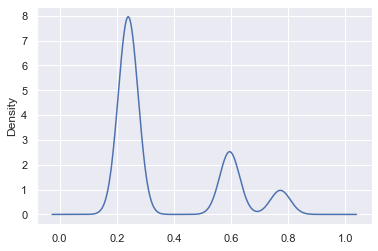

In [17]:
df1.P2.plot.kde()

### Building More Hinters

In [19]:
#Create columns to encode Hinters
df1['h3'] = df1['transcription'].str.contains('sponge')
#Hinter will alter P(S): 1st approx. if row is +ve wrt to hinter,take average, if row is -ve do nothing
# Update P(S) as follows
# if h1 is false, do nothing
#if h1 is true then, then take average P(S)  and  Weight(0.95),unless labeled

W =0.95
L= []
for index,row in df1.iterrows():
    if df1.iloc[index]['h3']:
        P3 = (df1.iloc[index]['P2'] +W)/2
        L.append(P3)
    else:
        P3 = df1.iloc[index]['P2']
        L.append(P3)
        
df1['P3'] = L

(0.0, 1.0)

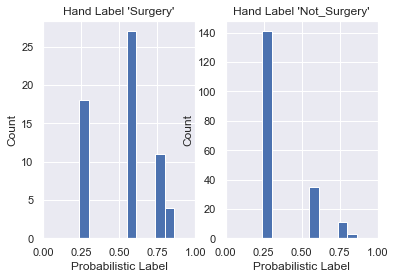

In [21]:
plt.subplot(1,2,1)
df1[df1.label == 1].P3.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
plt.xlim([0,1])
plt.subplot(1,2,2)
df1[df1.label == 0].P3.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
plt.xlim([0,1])

<AxesSubplot:ylabel='Density'>

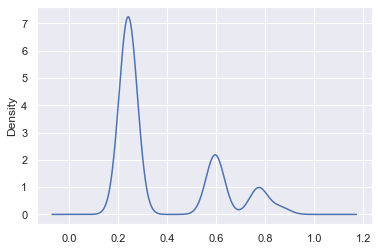

In [22]:
df1.P3.plot.kde()

Two things have happened, as we increased our number of hinters:
<br>
1. In our probabilistic confusion index, we've seen the histogram for those hand labeled 'Surgery' move to the right, which is good! We've also seen thehistogram for hand labeled 'Surgery' move slightly to the right, which we don't want. Note that this is because we have only introduced positive hinters so we may want to introduce negative hinters next or use a more sophisticated method of moving from hinter to probabilistic labels. 
<br>
2. Our label distribution plot now has more density above P(S) = 0.5 (more density on the right), which is also desirable. Recall what we would expect to see in the label distribution is -25% of our dataset with a near 100% chance of being surgery and -75% of it with a low chance of being surgery.

##  Learning a Generative Model for P-labels

Such hinters, although instructive as toy examples, can only be so performant. Let's now use a larger set of hinters to see how if we can build better training data.

We'll also use a more sophisticated method of moving from hinter to probabilistic label: instead of averaging over a weight and previous probabilistic prediction, we'll use a Naive Bayes model, which is a generative model. A generative model is one that models the joint probability **P(X,Y)** of features X and target Y, in contrast to discriminative models that model the conditional probability **P(Y|X)** of the target conditional on the features. A strength of using a generative model, as opposed to a discriminative model like a random forest, is that it allows us to model the complex relationships between the dat, the target variable, and the hinters: it allows us to answer questions such as "Which hinters are noisier than the others?" and "In which cases are they noisy?" For more on generative models, Google has a nice introduction here.

To do this, we create arrays that encode whether or not a hinter is present, for any given row. First, let's create lists of positive and negative hinters:

In [24]:
#List of Positive Hinters
pos_hinters = ['anesthesia', 'blade', 'sponge']
#List of Negative Hinters
neg_hinters =['psych', 'reflexes','pupils','married']

In [37]:
#For each hinter we will create an coulmn in the dataframe encoding whether the term is present or not.
for hinter in pos_hinters:
    df1[hinter] = df1['transcription'].str.contains(hinter,na=0).astype(int)
for hinter in neg_hinters:
    df1[hinter] = -df1['transcription'].str.contains(hinter,na=0).astype(int)

In [40]:
df1.shape

(4999, 21)

We now convert the labeled data into NumPy arrays and split it into training and validation sets, in order to train our probabilistic predictions on the former and test them on the latter (note we're currently using only positive hinters).

In [43]:
#extract labeled data
df_lab = df1[~df1['label'].isnull()]
#convert to numpy arrays
X = df_lab[pos_hinters].to_numpy()
y = df_lab['label'].to_numpy().astype(int)
#Splitting into train and test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)


In [44]:
#Now to train Bernoulli or Naive Bayes Algorith on train data
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[base_rate, 1-base_rate])
clf.fit(X_train,y_train)

BernoulliNB(class_prior=[0.24, 0.76])

With this trained model let's now make our probabilistic prdiction on our validation(or test) set  and visualize our probabilistic confusion index  to compaire our prediction with our hand labels

In [47]:
proba_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': proba_test[:,1]})


(0.0, 1.0)

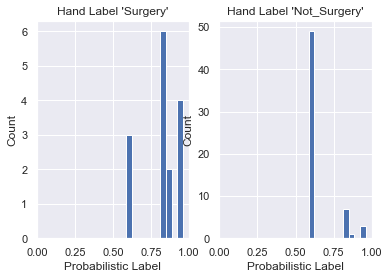

In [49]:
plt.subplot(1,2,1)
df_val[df_val.label == 1].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
plt.xlim([0,1])
plt.subplot(1,2,2)
df_val[df_val.label == 0].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
plt.xlim([0,1])

This is cool! Using more hinters and a Naive Bayes model, we see that we've managed to increase the number of true positives and true negatives. This is visible in the plots above as the histogram for the hand label 'Sugery' is skewed more to the right and the histogram for 'Not Surgery' to the left.
Now let's plot the entire label distribution plot:

<AxesSubplot:ylabel='Density'>

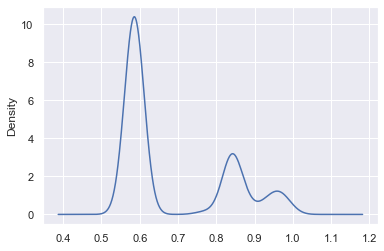

In [50]:
probs_all = clf.predict_proba(df1[pos_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde()

This is a significant improvement to our previous labels, as we have far more density closer to 1. Let's now see if we can make any performance gains adding in the negative hinters

In [55]:
#extract labeled data
df_lab = df1[~df1['label'].isnull()]
#convert to numpy arrays
X = df_lab[pos_hinters + neg_hinters].to_numpy()
y = df_lab['label'].to_numpy().astype(int)
#Splitting into train and test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [56]:
#Now to train Bernoulli or Naive Bayes Algorith on train data
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[base_rate, 1-base_rate])
clf.fit(X_train,y_train)

BernoulliNB(class_prior=[0.24, 0.76])

Let's plot the Probabilistic Confusion Index and the  label distribution plot

In [57]:
proba_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': proba_test[:,1]})

Text(0.5, 1.0, "Hand Label 'Not_Surgery'")

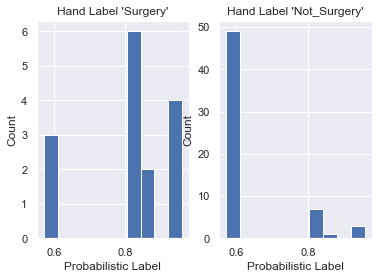

In [60]:
plt.subplot(1,2,1)
df_val[df_val.label == 1].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
# plt.xlim([0,1])
plt.subplot(1,2,2)
df_val[df_val.label == 0].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
# plt.xlim([0,1])

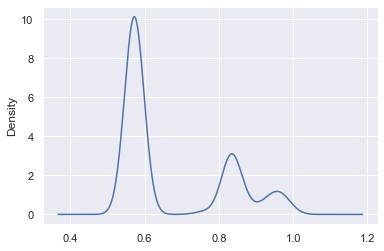

In [61]:
probs_all  = clf.predict_proba(df1[pos_hinters + neg_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde();

In [62]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df['medical_specialty'].str.contains('Surgery'),df1['pred'].gt(0.6),average='macro')

(0.6739608027798525, 0.7205457722719963, 0.6848020319915347, None)

## Lesson 3: Weak Signal Generation

We could obviously continue this process above with larger lists of positive and negative hinters, but creating those hinters manually can still be arduous work. Weak supervision tends to perform best with large quantities of independent sources of signal, so driving through that process by sitting at a computer thinking about different hinters you could create is slow work.

We can try automatically generating some hinters using simple clustering and similarity techniques. For instance,let's see what we can do just leveraing TF-IDF and K-Means

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords

In [65]:
def preprocessing_text(text: str,remove_stopwords:bool) ->str:
    if not pd.isnull(text):
        if remove_stopwords:
            tokens = nltk.word_tokenize(text)
            tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
            text  = " ".join(tokens)
        text = text.lower().strip()
    return text

In [66]:
df['cleaned'] = df['transcription'].apply(lambda x : preprocessing_text(x,remove_stopwords=True))

We'll use TF-IDF to convert our transcriptions into a numerical format by identifying specific terms that are rare and likely predictive of our class.


TF stands for term frequency, while IDF stands for inverse document frequency. The TF-IDF value increases proportionally to the number of times a word appears in the document, and is offset by the number of documents in the corpus that contain that word.

In [69]:
# initlaize the vectorizer 
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,max_df=0.95)
#fit transform applies to TF-IDF  to clean the transcription
X = vectorizer.fit_transform(df['cleaned'].values.astype('U'))

<br>
X is the array of vectors that will be used to train the KMeans model. The default behavior of Sklearn is to create a sparse matrix. 

Vectorization generates vectors similar to this:
vector_a = (1.204, 0, 0, 0, 0, ..., 0]

We can actually plug this straight into our KMeans model

In [70]:
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

We have our X from the Tf-IDF vectorization and we have a KMeans model and related clusters. Now we want to put these two pieces together to understand the relationship between text and group.

In [71]:
df['clusters'] = clusters

In [72]:
df.head()

,index,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,cleaned,clusters
0,84,84,An example/template for meatotomy.,Urology,Meatotomy Template,"OPERATIVE NOTE: ,The patient was taken to the...","urology, urethral meatus, mosquito hemostat, m...","operative note : , patient taken operating roo...",2
1,2470,2470,Normal physical exam template. Normal appear...,Office Notes,Normal Physical Exam Template - 6,"VITAL SIGNS:, Reveal a blood pressure of *, t...","office notes, jugular venous distention, flank...","vital signs : , reveal blood pressure * , temp...",0
2,2804,2804,Neurologic consultation was requested to asse...,Neurology,Neurologic Consultation - 3,"HISTORY: , Neurologic consultation was request...","neurology, eye blinking, status epilepticus, s...","history : , neurologic consultation requested ...",0
3,4987,4987,"Multiple sharp force injuries, involving ches...",Autopsy,Autopsy - 6,"ANATOMICAL SUMMARY,1. Sharp force wound of nec...",NaN,"anatomical summary,1 . sharp force wound neck ...",1
4,4924,4924,The patient with atypical type right arm disc...,Cardiovascular / Pulmonary,Cardiac Catheterization - 2,"INDICATIONS FOR PROCEDURE:, The patient has pr...","cardiovascular / pulmonary, discomfort, subcla...","indications procedure : , patient presented at...",1


Let's check the relevant Keywords for each centriod and see if we caught anything interesting

In [74]:
def top_keyswords(n_terms):
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # group the TF-IDF vectors by cluster
    terms = vectorizer.get_feature_names_out() #access the tf-idf terms 
    for i,r in df.iterrows():
        print('\ncluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r) [-n_terms:]]))  # for each row of the dataframe, find the n terms that 
        
top_keyswords(50)


cluster 0
soft,respiratory,sounds,edema,discharge,dr,pressure,vital,hypertension,today,social,well,plan,time,heent,without,signs,illness,old,disease,also,day,abdomen,blood,regular,year,review,systems,daily,neck,family,present,extremities,negative,rate,chest,heart,examination,physical,medical,clear,allergies,denies,medications,normal,pain,mg,past,patient,history

cluster 1
lesion,aortic,reason,scope,technique,throughout,moderate,valve,advanced,mg,distal,anterior,diagnosis,evaluation,mri,stenosis,revealed,significant,coronary,also,lower,noted,small,disease,images,within,cm,time,contrast,ct,well,without,artery,obtained,performed,history,unremarkable,pain,mild,seen,findings,impression,evidence,procedure,exam,nan,patient,left,normal,right

cluster 2
noted,sutures,usual,lateral,identified,supine,tolerated,brought,mm,dissection,anterior,fascia,hemostasis,needle,wound,complications,tissue,recovery,area,applied,condition,general,well,performed,suture,position,made,draped,postoperative,preopera

Cluster 2 seems to be fairly close to what we're looking for regarding 'Surgery' related concepts, while Clusters 0 and 1 seem to have some terms that might be more closely aligned to regular check ups. We can tweak the number of clusters we want to look at here, but for the sake of this demonstration we'll just stick to 3. We can use these keywords to create larger positive and negative hinter lists and we'll see how that improves our performance.

First, let's re-plot the charts from before for the sake of comparison.

Text(0.5, 1.0, "Hand Label 'Not_Surgery'")

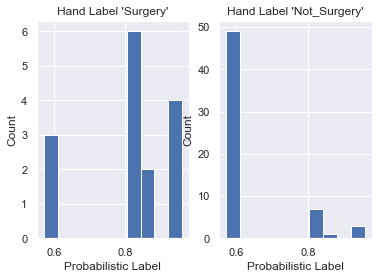

In [75]:
proba_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': proba_test[:,1]})
plt.subplot(1,2,1)
df_val[df_val.label == 1].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
# plt.xlim([0,1])
plt.subplot(1,2,2)
df_val[df_val.label == 0].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
# plt.xlim([0,1])

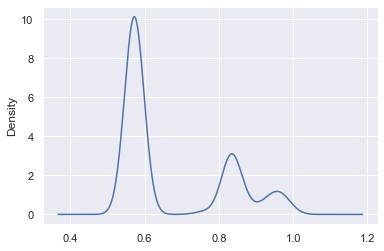

In [76]:
probs_all  = clf.predict_proba(df1[pos_hinters + neg_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde();

Next, let's update  our hinters lists by drawing from the keywords in the clustering above

In [77]:
#List of Positive Hinters
pos_hinters = ['anesthesia', 'blade', 'sponge','prepped','vicryl', 'sterile','operating','room','fashion', 'incision','procedure','closed','diagnosis','lateral','supine','dissection','fascia','hemostasis','needle','complications','tissue','draped']
#List of Negative Hinters
neg_hinters =['psych', 'reflexes','pupils','married','history','findings','unremarkable','allergies','normal','medical','family','examination','physical']

In [78]:
#For each hinter we will create an coulmn in the dataframe encoding whether the term is present or not.
for hinter in pos_hinters:
    df1[hinter] = df1['transcription'].str.contains(hinter,na=0).astype(int)
for hinter in neg_hinters:
    df1[hinter] = -df1['transcription'].str.contains(hinter,na=0).astype(int)

In [79]:
#extract labeled data
df_lab = df1[~df1['label'].isnull()]
#convert to numpy arrays
X = df_lab[pos_hinters + neg_hinters].to_numpy()
y = df_lab['label'].to_numpy().astype(int)

#Splitting into train and test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#Time to train our NB model
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[base_rate, 1-base_rate])
clf.fit(X_train,y_train)

BernoulliNB(class_prior=[0.24, 0.76])

Text(0.5, 1.0, "Hand Label 'Not_Surgery'")

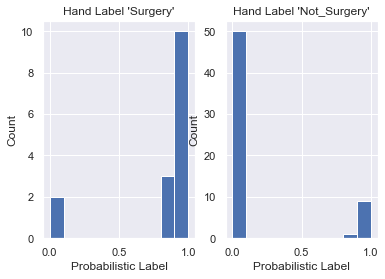

In [80]:
proba_test = clf.predict_proba(X_test)
df_val = pd.DataFrame({'label': y_test, 'pred': proba_test[:,1]})
plt.subplot(1,2,1)
df_val[df_val.label == 1].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Surgery'")
# plt.xlim([0,1])
plt.subplot(1,2,2)
df_val[df_val.label == 0].pred.hist();
plt.xlabel("Probabilistic Label")
plt.ylabel("Count")
plt.title("Hand Label 'Not_Surgery'")
# plt.xlim([0,1])

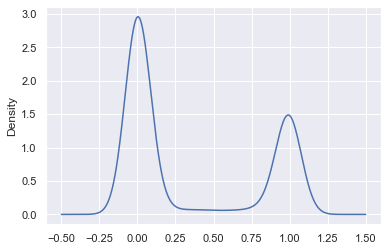

In [81]:
probs_all  = clf.predict_proba(df1[pos_hinters + neg_hinters].to_numpy())
df1['pred'] = probs_all[:,1]
df1.pred.plot.kde();

In [82]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df['medical_specialty'].str.contains('Surgery'),df1['pred'].gt(0.6),average='macro')

(0.6904720905799, 0.7444044675512411, 0.7026190578634748, None)

This is a huge improvement over our manually created hinters. We're able to get clear separation between low-probability and high-probability labels, and overall clear alignment with what we are considering as "ground truth". There are many ways to expand on this idea of hinter generation, but this was meant to be a simplistic example to demonstrate how effective these techniques can be when used correctly.


Let's finally take a look at some of the predictions just for some spot checking

In [84]:
df1[['transcription','medical_specialty', 'pred']].loc[df1['pred']> 0.9]

,transcription,medical_specialty,pred
0,"OPERATIVE NOTE: ,The patient was taken to the...",Urology,0.998361
5,"CLINICAL HISTORY: ,This 78-year-old black woma...",Cardiovascular / Pulmonary,0.994339
7,"PREOPERATIVE DIAGNOSIS: , Penoscrotal abscess....",Surgery,0.989826
9,"PREOPERATIVE DIAGNOSIS: , Ruptured distal bice...",Surgery,0.996335
15,"PROCEDURES: , Total knee replacement.,PROCEDUR...",Surgery,0.974215
...,...,...,...
4978,"PREOPERATIVE DIAGNOSIS: , Left carpal tunnel s...",Surgery,0.996338
4985,"PREOPERATIVE DIAGNOSES,1. Basal cell carcinom...",Surgery,0.999908
4986,"NORMAL CATARACT SURGERY,PROCEDURE DETAILS: , T...",Ophthalmology,0.999148
4995,"HISTORY: , The patient is a 5-1/2-year-old, wh...",Surgery,0.922016


 **Note: we blindly trusted the Medical_specialty column as our ground truth, but as we can see it's anything but. There are cases where the Medical_specialty likely should've included Surgery but did not.**